In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pickle

from tmu.models.autoencoder.autoencoder import TMAutoEncoder
from src.lib.care import calculate_care_score

In [25]:
def load_test_dataset(farm, event_id):
    X = np.loadtxt(f"./data_test/X_{farm}_{event_id}.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)
    return X


def load_test_labels(farm, event_id):
    y = np.loadtxt(f"./data_test/y_{farm}_{event_id}.txt", dtype=np.uint32)
    y = np.array(y).astype(np.uint32)
    return y


def load_test_status_labels(farm, event_id):
    z = np.loadtxt(f"./data_test/z_{farm}_{event_id}.txt", dtype=np.uint32)
    z = np.array(z).astype(np.uint32)
    return z


def load_test_label(farm, event_id):
    event_info = pd.read_csv(f"../../../data/care_to_compare/Wind Farm {farm}/event_info.csv", delimiter=';')

    metadata = event_info[event_info['event_id'] == event_id]

    event_label = metadata["event_label"].values[0]

    return False if event_label == "anomaly" else True

In [26]:
def load_model(filename) -> TMAutoEncoder:
    with open(filename, "rb") as f:
        model = pickle.load(f)

    return model

In [27]:
def calculate_accuracy(labels, predictions):
    # Calculate the accuracy
    accuracy = np.sum(labels == predictions) / len(labels)

    return accuracy

In [28]:
def reconstruction_accuracy(X, pred):
    correct = np.sum(X == pred)
    accuracy = correct / len(X)
    return accuracy


def plot_mse(X, y, pred, name, threshold):
    # Compute MSE for each row
    mse_per_row = [reconstruction_accuracy(X[i], pred[i]) for i in range(len(X))]

    # Plot SNS plot of all MSE values
    plt.figure(figsize=(8, 4))
    sns.histplot(mse_per_row, bins=50, kde=True, color='b')

    # Add a threshold line
    plt.axvline(threshold, color='r', linestyle='--')

    # Save the plot
    #plt.savefig(f"./plot_mse_hist_{name}.png")
    plt.show()


def get_predictions(X, y):
    tm = load_model("run2/latest_24.pkl")

    pred = tm.predict(X)

    threshold = 0.75

    # For each row in pred, if the MSE is greater than the threshold, then it is an anomaly
    losses = [calculate_accuracy(X[i], pred[i]) for i in range(len(X))]

    X_predictions = np.array([1 if losses[i] < threshold else 0 for i in range(len(X))])

    # Accuracy
    accuracy = calculate_accuracy(y, X_predictions)

    plot_mse(X, y, pred, "test", threshold)

    return X_predictions, accuracy

In [29]:
test_datasets = [34, 7, 53, 27, 19, 77, 83, 52, 21, 2, 23, 87, 74, 86, 82]


def run_prediction(farm, dataset):
    X = load_test_dataset(farm, dataset)
    y = load_test_labels(farm, dataset)
    z = load_test_status_labels(farm, dataset)

    is_normal = load_test_label(farm, dataset)

    predictions, accuracy = get_predictions(X, y)

    return X, y, z, is_normal, predictions, accuracy


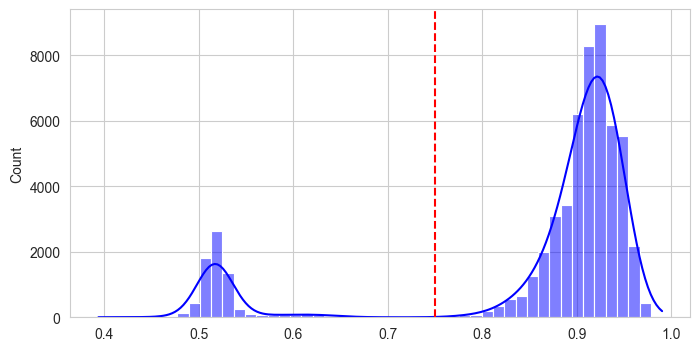

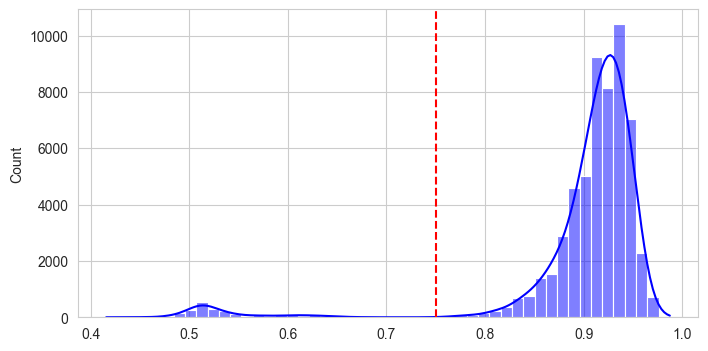

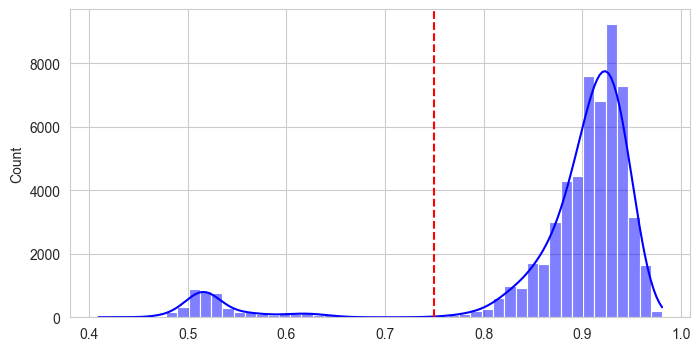

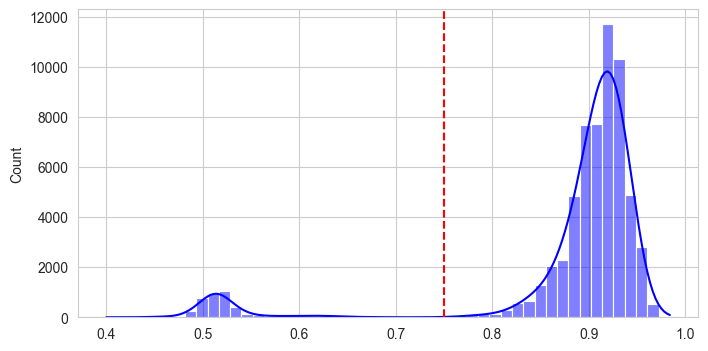

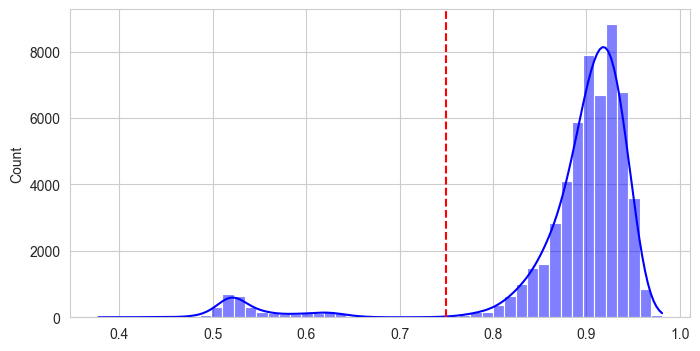

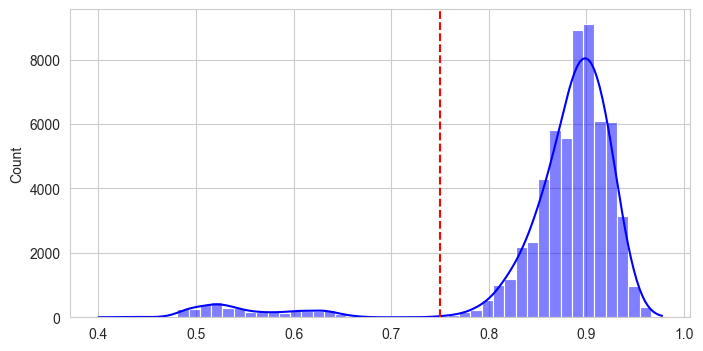

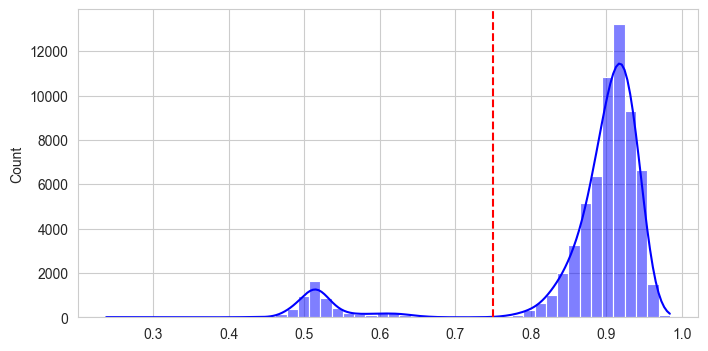

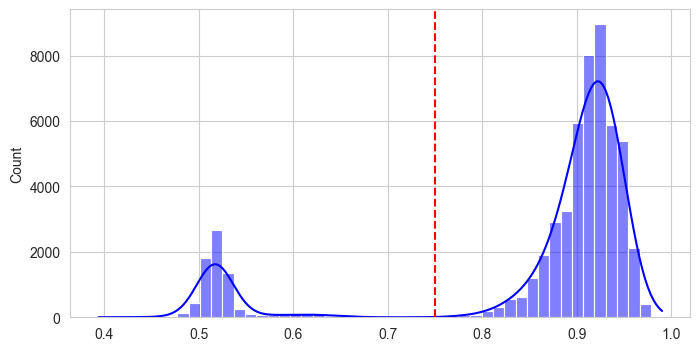

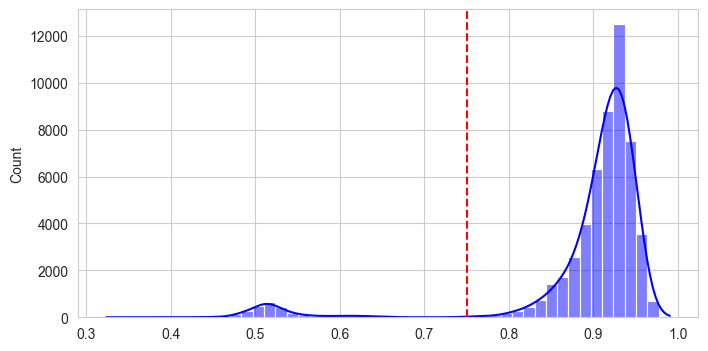

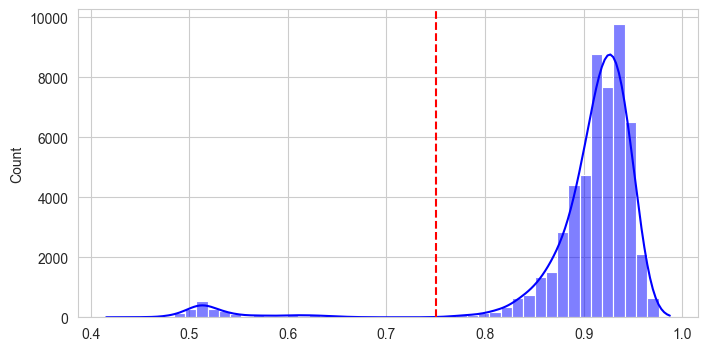

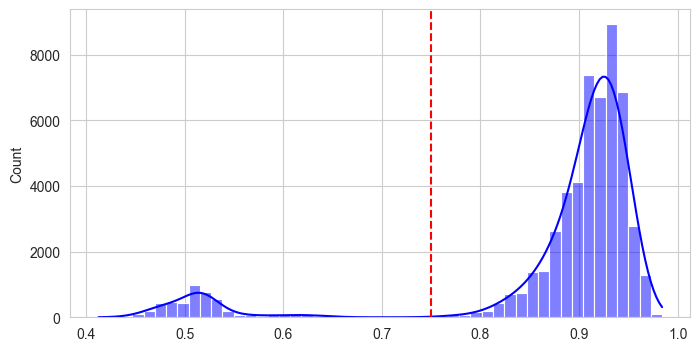

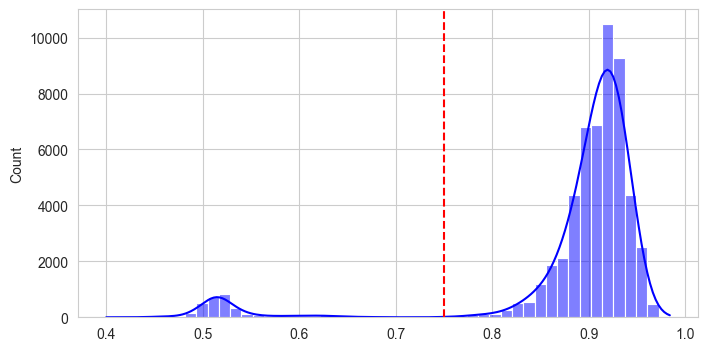

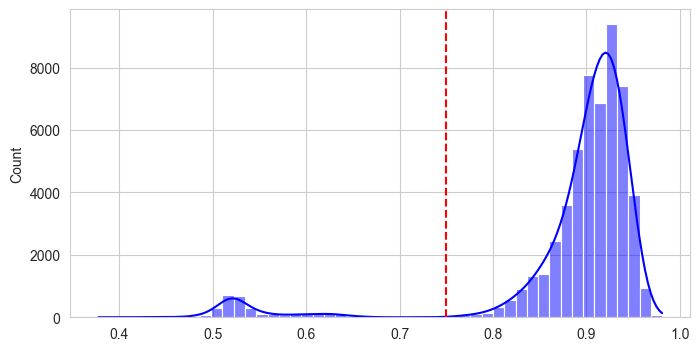

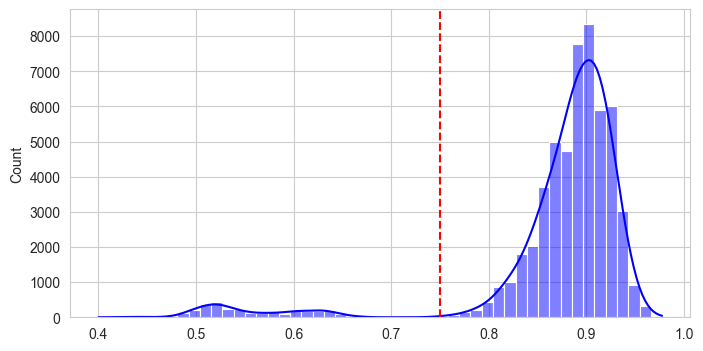

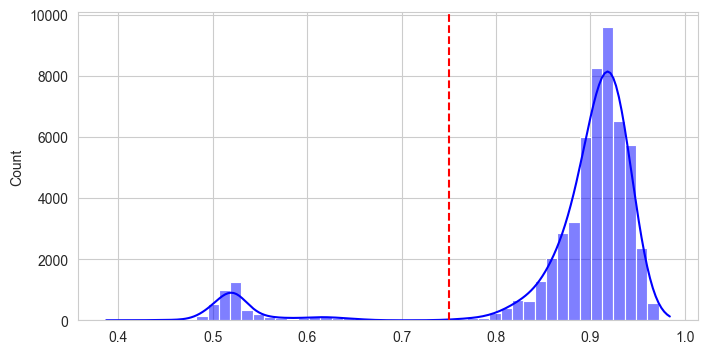

In [30]:
# Create a dataframe with status_type_id;label;prediction

elements = []

for set in test_datasets:
    res = run_prediction("B", set)

    result_df = pd.DataFrame({
        'status_type_id': res[2],
        'label': res[1],
        'prediction': res[4]
    })

    elements.append({'dataset': set, 'normal': res[3], 'data': result_df, 'accuracy': res[5]})

In [33]:
score = calculate_care_score(elements)
print(score)

0.7104712010526815
